# Hackaton pictoria 19.12.2024

Inspiration : [ce tutoriel tensorflow](https://www.tensorflow.org/tutorials/images/classification)

## Installations et imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Préparer le dataset

D'abord, on charge deux datasets: 
- `train_ds`, le dataset d'entrainement
- `val_ds`, le dataset de validation

In [3]:
# DATA_DIR est le chemin depuis le dossier actuel vers `data`
# et devra peut-être être adapté selon vos envies
DATA_DIR = os.path.join( os.path.dirname(os.path.abspath("")), "data" )
print(DATA_DIR)

# chemins vers les datasets
dataset_training_path   = os.path.join(DATA_DIR, "dataset_train/")
dataset_validation_path = os.path.join(DATA_DIR, "dataset_valid/")

# paramètres
batch_size = 32
img_height = 180
img_width = 180

# dataset de train. en fait, on utilise un seul dataset en 80/20
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_training_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
# dataset de validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_training_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
# les noms de classe correspondent aux sous-dossiers de notre `data_dir`
class_names = train_ds.class_names

/home/sarah/dev/hackathon/traitement/data
Found 14144 files belonging to 42 classes.
Using 11316 files for training.


2024-12-20 14:49:33.694074: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-20 14:49:33.694155: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: user-Precision-3591
2024-12-20 14:49:33.694163: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: user-Precision-3591
2024-12-20 14:49:33.694363: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2024-12-20 14:49:33.694420: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2024-12-20 14:49:33.694425: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


Found 14144 files belonging to 42 classes.
Using 2828 files for validation.


On récupère quelques infos sur le dataset et on regarde ce qu'il a dans le ventre.

In [4]:
# describe the dataset
dataset_unbatched = tuple(train_ds.unbatch())
labels = [ label.numpy() for (image,label) in dataset_unbatched ]
labels = pd.Series(labels)
count  = labels.value_counts().sort_index()
count.index = train_ds.class_names
count = pd.DataFrame([count]).transpose().reset_index(names="class_name")
print(count)

                          class_name  count
0                   affiche ou tract     31
1                             animal     16
2                            arrière    205
3                              avion    251
4                             bateau     58
5                       bombardement    438
6                           campagne     64
7                    capture d'écran    733
8                    carnet de sucre     35
9                              carte     28
10                carte géographique    589
11  carte géographique,carte postale      3
12                     carte postale    117
13                          charnier     45
14                      construction     43
15                       distinction     22
16           document dactylographié      3
17                 document illustré   1831
18                document manuscrit    689
19                             foule    177
20                             livre    454
21                              

2024-12-20 14:49:52.680632: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-12-20 14:49:59.507381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


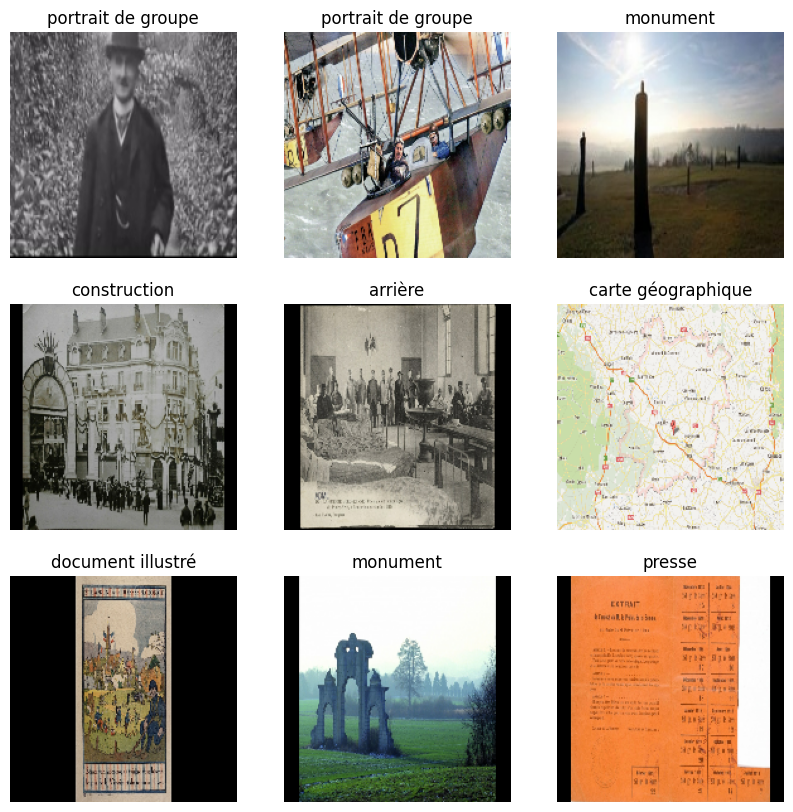

In [5]:
# petite visualisation pour voir ce qu'il se passe à la fraiche
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Ensuite, on configure le dataset pour accélérer le training 

In [6]:
# `.cache()` permet de stocker les images déjà ouvertes en mémoire pour ne pas faire exploser l'I/O
# `.prefetch()` "overlaps data preprocessing and model execution while training."
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Créer le modèle

D'après le tutoriel, 
> The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [7]:
num_classes = len(class_names)

# le modèle est défini comme une liste de layers.
model = Sequential([
    # la première couche permet d'optimiser le modèle:
    # les images ont 3 bandes RGB qui sont représentées sur une échelle 0..255.
    # cette couche les représente sur une échelle 0..1 parce que des petites valeurs sont mieux pour le ML
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# on compile le modèle
model.compile( optimizer='adam'                                                       # algo d'optimisation
             , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)   # loss function
             , metrics=['accuracy']                                                   # metrics permet de voir l'accuracy à chaque `epoch`
             )
model.summary()

/home/sarah/.cache/pypoetry/virtualenvs/hackathon-zQr_VwBP-py3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,994,058 (15.24 MB)

 Trainable params: 3,994,058 (15.24 MB)

 Non-trainable params: 0 (0.00 B)

## Train le modèle

On entraîe le modèle sur notre dataset.

In [8]:
epochs=10
history = model.fit( train_ds
                   , validation_data=val_ds
                   , epochs=epochs )


Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.3399 - loss: 2.4638 - val_accuracy: 0.5668 - val_loss: 1.5788
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.6520 - loss: 1.2573 - val_accuracy: 0.7100 - val_loss: 1.0662
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.8521 - loss: 0.5451 - val_accuracy: 0.8281 - val_loss: 0.7788
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.9394 - loss: 0.2467 - val_accuracy: 0.8529 - val_loss: 0.7357
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.9670 - loss: 0.1405 - val_accuracy: 0.8695 - val_loss: 0.7179
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.9793 - loss: 0.1078 - val_accuracy: 0.8791 - val_loss: 0.6798
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9844 - loss: 0.0854 - val_accuracy: 0.8798 - val_loss: 0.7257
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9884 - loss: 0

## Voir les résultats

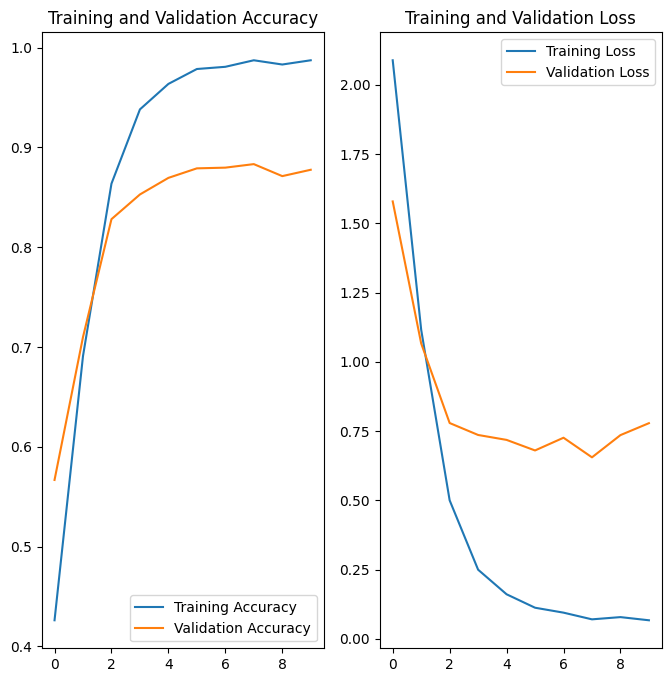

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()